In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Data Cleaning and Preparation")
print("=" * 50)

Data Cleaning and Preparation


In [2]:
# Cell 2: Load Data
df = pd.read_csv('../raw_data/metadata.csv', low_memory=False)
print(f"Original dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display basic info
print("\nDataset Overview:")
print(df.info())

Original dataset shape: (1056660, 19)
Memory usage: 2784.27 MB

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056660 entries, 0 to 1056659
Data columns (total 19 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   cord_uid          1056660 non-null  object 
 1   sha               373766 non-null   object 
 2   source_x          1056660 non-null  object 
 3   title             1056157 non-null  object 
 4   doi               656780 non-null   object 
 5   pmcid             389571 non-null   object 
 6   pubmed_id         498932 non-null   object 
 7   license           1056660 non-null  object 
 8   abstract          821116 non-null   object 
 9   publish_time      1054846 non-null  object 
 10  authors           1032791 non-null  object 
 11  journal           969338 non-null   object 
 12  mag_id            0 non-null        float64
 13  who_covidence_id  482935 non-null   object 
 14  arxiv_id        

Missing Data Analysis:
              Column  Missing_Count  Missing_Percent
12            mag_id        1056660       100.000000
14          arxiv_id        1042411        98.651506
16    pmc_json_files         740918        70.118865
15    pdf_json_files         682894        64.627600
1                sha         682894        64.627600
5              pmcid         667089        63.131849
13  who_covidence_id         573725        54.296084
6          pubmed_id         557728        52.782163
4                doi         399880        37.843772
17               url         369726        34.990063
8           abstract         235544        22.291371
11           journal          87322         8.263964
18             s2_id          80192         7.589196
10           authors          23869         2.258910
9       publish_time           1814         0.171673


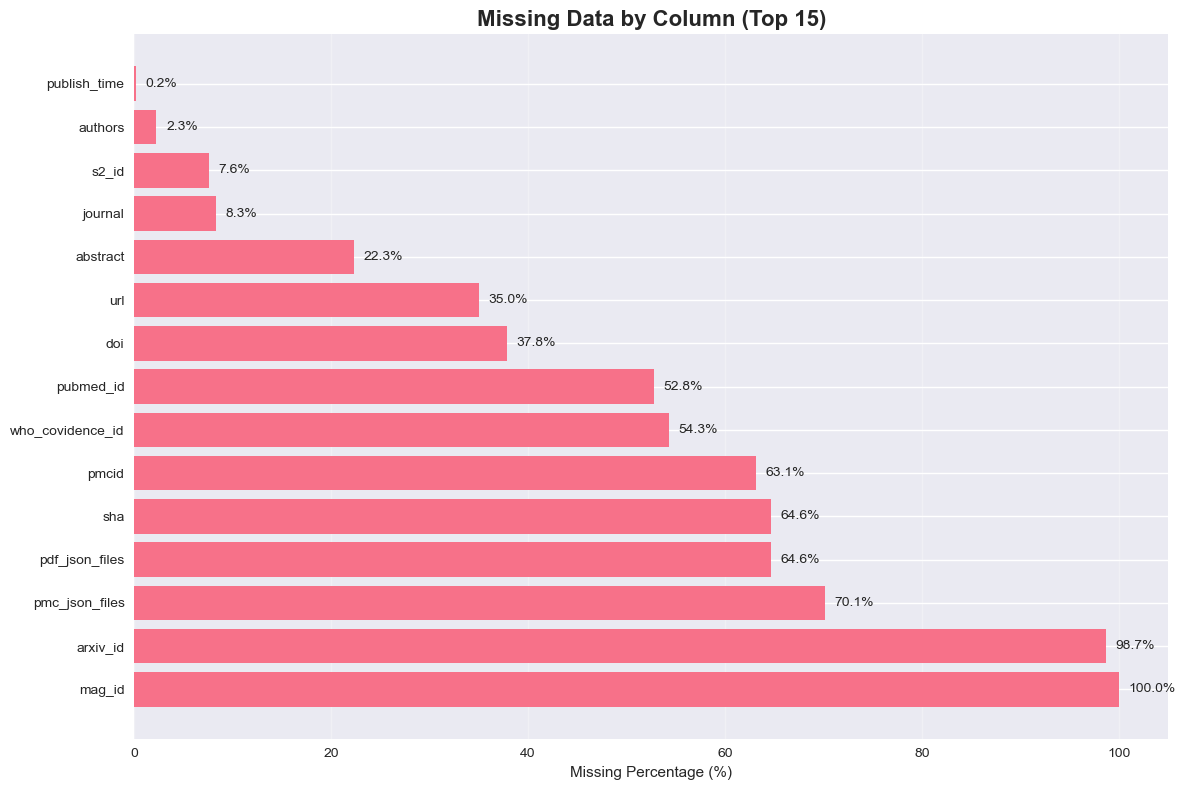

In [3]:
# Cell 3: Analyze Missing Data
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing_data.index,
    'Missing_Count': missing_data.values,
    'Missing_Percent': missing_percent.values
}).sort_values('Missing_Percent', ascending=False)

print("Missing Data Analysis:")
print(missing_df.head(15))

# Visualize missing data
plt.figure(figsize=(12, 8))
top_missing = missing_df.head(15)
bars = plt.barh(range(len(top_missing)), top_missing['Missing_Percent'])
plt.yticks(range(len(top_missing)), top_missing['Column'])
plt.xlabel('Missing Percentage (%)')
plt.title('Missing Data by Column (Top 15)', fontsize=16, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Add percentage labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}%', ha='left', va='center')

plt.tight_layout()
plt.savefig('../visuals/missing_data_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [4]:
# Cell 4: Data Cleaning Strategy
print("Data Cleaning Strategy:")
print("-" * 30)

# Keep essential columns for analysis
essential_columns = [
    'cord_uid', 'title', 'abstract', 'authors', 'publish_time', 
    'journal', 'source_x', 'doi', 'url'
]

# Filter to essential columns that exist
available_columns = [col for col in essential_columns if col in df.columns]
df_clean = df[available_columns].copy()

print(f"Reduced from {df.shape[1]} to {len(available_columns)} columns")
print(f"Available columns: {available_columns}")

Data Cleaning Strategy:
------------------------------
Reduced from 19 to 9 columns
Available columns: ['cord_uid', 'title', 'abstract', 'authors', 'publish_time', 'journal', 'source_x', 'doi', 'url']


In [5]:
# Cell 5: Clean Individual Columns
# Clean publish_time
print("Cleaning publish_time column...")
df_clean['publish_time'] = pd.to_datetime(df_clean['publish_time'], errors='coerce')

# Extract additional date features
df_clean['publication_year'] = df_clean['publish_time'].dt.year
df_clean['publication_month'] = df_clean['publish_time'].dt.month
df_clean['publication_date'] = df_clean['publish_time'].dt.date

# Focus on COVID-19 era (2019-2023)
covid_years = df_clean['publication_year'].between(2019, 2023)
df_clean = df_clean[covid_years].copy()

print(f"After filtering to COVID-19 era: {df_clean.shape}")

Cleaning publish_time column...
After filtering to COVID-19 era: (475208, 12)


In [6]:
# Cell 6: Text Processing
print("Processing text columns...")

# Clean titles
df_clean['title'] = df_clean['title'].fillna('No Title Available')
df_clean['title_word_count'] = df_clean['title'].str.split().str.len()

# Clean abstracts
df_clean['abstract'] = df_clean['abstract'].fillna('No Abstract Available')
df_clean['abstract_word_count'] = df_clean['abstract'].str.split().str.len()

# Clean authors
df_clean['authors'] = df_clean['authors'].fillna('Unknown Authors')
df_clean['author_count'] = df_clean['authors'].str.split(';').str.len()

# Clean journal
df_clean['journal'] = df_clean['journal'].fillna('Unknown Journal')

# Clean source
if 'source_x' in df_clean.columns:
    df_clean['source'] = df_clean['source_x'].fillna('Unknown Source')
else:
    df_clean['source'] = 'Unknown Source'

print("Text processing completed!")

Processing text columns...
Text processing completed!


In [7]:
# Cell 7: Remove Duplicates and Final Cleaning
print("Final cleaning steps...")

# Remove duplicates based on title
initial_count = len(df_clean)
df_clean = df_clean.drop_duplicates(subset=['title'], keep='first')
print(f"Removed {initial_count - len(df_clean)} duplicate titles")

# Remove rows with no meaningful content
meaningful_content = (
    (df_clean['title'] != 'No Title Available') | 
    (df_clean['abstract'] != 'No Abstract Available')
)
df_clean = df_clean[meaningful_content].copy()

# Final dataset info
print(f"\nFinal cleaned dataset shape: {df_clean.shape}")
print(f"Date range: {df_clean['publication_year'].min()} - {df_clean['publication_year'].max()}")

Final cleaning steps...
Removed 9308 duplicate titles

Final cleaned dataset shape: (465899, 16)
Date range: 2019.0 - 2023.0


In [8]:
# Cell 8: Save Cleaned Data
print("Saving cleaned dataset...")
df_clean.to_csv('../raw_data/metadata_cleaned.csv', index=False)
print("Cleaned data saved as 'metadata_cleaned.csv'")

# Create summary statistics
summary_stats = {
    'Total Papers': len(df_clean),
    'Date Range': f"{df_clean['publication_year'].min()}-{df_clean['publication_year'].max()}",
    'Unique Journals': df_clean['journal'].nunique(),
    'Avg Title Length': f"{df_clean['title_word_count'].mean():.1f} words",
    'Avg Abstract Length': f"{df_clean['abstract_word_count'].mean():.1f} words",
    'Papers with Abstracts': f"{(df_clean['abstract'] != 'No Abstract Available').sum():,}"
}

print("\nDataset Summary:")
for key, value in summary_stats.items():
    print(f"{key}: {value}")

Saving cleaned dataset...
Cleaned data saved as 'metadata_cleaned.csv'

Dataset Summary:
Total Papers: 465899
Date Range: 2019.0-2023.0
Unique Journals: 16863
Avg Title Length: 13.6 words
Avg Abstract Length: 174.2 words
Papers with Abstracts: 375,384
